In [1]:
import numpy as np
import pandas as pd

from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization 
from tensorflow.keras.utils import to_categorical

from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

import seaborn as sns
import os
import glob
import plotly.graph_objects as go
import cv2
from PIL import Image
from PIL import ImageFile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tqdm import tqdm

# **데이터**

In [2]:
root_dir = '../input/intel-mobileodt-cervical-cancer-screening'
train_dir = os.path.join(root_dir,'train', 'train')

type1_dir = os.path.join(train_dir, 'Type_1')
type2_dir = os.path.join(train_dir, 'Type_2')
type3_dir = os.path.join(train_dir, 'Type_3')

train_type1_files = glob.glob(type1_dir+'/*.jpg')
train_type2_files = glob.glob(type2_dir+'/*.jpg')
train_type3_files = glob.glob(type3_dir+'/*.jpg')

added_type1_files  =  glob.glob(os.path.join(root_dir, "additional_Type_1_v2", "Type_1")+'/*.jpg')
added_type2_files  =  glob.glob(os.path.join(root_dir, "additional_Type_2_v2", "Type_2")+'/*.jpg')
added_type3_files  =  glob.glob(os.path.join(root_dir, "additional_Type_3_v2", "Type_3")+'/*.jpg')

type1_files = train_type1_files + added_type1_files
type2_files = train_type2_files + added_type2_files
type3_files = train_type3_files + added_type3_files

print(f'''Type 1 files for training: {len(type1_files)} 
Type 2 files for training: {len(type2_files)}
Type 3 files for training: {len(type3_files)}''' )

Type 1 files for training: 1441 
Type 2 files for training: 4348
Type 3 files for training: 2426


In [3]:
# 정리된 files_df 사용
files_df = pd.read_csv('../input/cervical-dropfiles/dropfiles.csv', sep=',').drop('Unnamed: 0', axis=1)
files_df

,filepath,label
0,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
1,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
2,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
3,../input/intel-mobileodt-cervical-cancer-scree...,Type 2
4,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
...,...,...
8207,../input/intel-mobileodt-cervical-cancer-scree...,Type 2
8208,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
8209,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
8210,../input/intel-mobileodt-cervical-cancer-scree...,Type 2


In [4]:
# get count of each type 
type_count = pd.DataFrame(files_df['label'].value_counts()).rename(columns= {'label': 'Num_Values'})
type_count

,Num_Values
Type 2,4346
Type 3,2426
Type 1,1440


In [5]:
#pie chart

pie_plot = go.Pie(labels= type_count.index.to_list(), values= type_count.values.flatten(),
                 hole= 0.2, text= type_count.index.to_list(), textposition='auto')
fig = go.Figure([pie_plot])
fig.update_layout(title_text='Pie Chart of Type Distribution')
fig.show()

## Split

In [4]:
# Train / Validation

train_df, valid_df = train_test_split(files_df, test_size = 0.2, stratify = files_df['label'], random_state = 1234)

print(len(train_df), len(valid_df))

6569 1643


In [5]:
X_train = train_df[['filepath']]
y_train = train_df[['label']]
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [6]:
X_valid = valid_df[['filepath']].reset_index(drop=True)
y_valid = valid_df[['label']].reset_index(drop=True)

print(len(X_train), len(y_train), len(X_valid),len(y_valid))

6569 6569 1643 1643


## pre-processing

In [9]:
# check original image size

(cv2.imread(train_df['filepath'].values[0])).shape

(4160, 3120, 3)

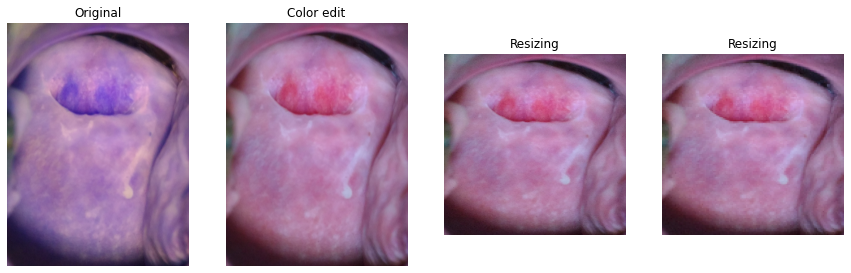

In [10]:
# load image

fig = plt.figure(figsize= (15,6))
fig.add_subplot(1,4,1)
plt.imshow(cv2.imread(train_df['filepath'].values[0]))
plt.axis(False)
plt.title('Original')

fig.add_subplot(1,4,2)
plt.imshow(cv2.cvtColor(cv2.imread(train_df['filepath'].values[0]),cv2.COLOR_RGB2BGR))
plt.axis(False)
plt.title('Color edit')

fig.add_subplot(1,4,3)
plt.imshow(cv2.resize(cv2.cvtColor(cv2.imread(train_df['filepath'].values[0]),cv2.COLOR_RGB2BGR),(224,224)))
plt.axis(False)
plt.title('Resizing')

fig.add_subplot(1,4,4)
plt.imshow(cv2.resize(cv2.cvtColor(cv2.imread(train_df['filepath'].values[0]),cv2.COLOR_RGB2BGR),(128,128)))
plt.axis(False)
plt.title('Resizing')

plt.show()

In [7]:
# train data (X normalize)

X_train = np.load('../input/data128/X_train_128.npy')/255
y_train = np.load('../input/data128/y_train_128.npy', allow_pickle=True)

In [8]:
# validation data (X normalize)

X_valid = np.load('../input/data128/X_valid_128.npy', allow_pickle=True)/255
y_valid = np.load('../input/data128/y_valid_128.npy', allow_pickle=True)

In [9]:
# y ONE HOT ENCODING
le = LabelEncoder().fit(['Type 1', 'Type 2', 'Type 3'])
y_train = le.transform(y_train)
y_valid = le.transform(y_valid)

y_train_onehot = to_categorical(y_train, num_classes=3)
y_valid_onehot = to_categorical(y_valid, num_classes=3)

# **모델링**

In [10]:
BATCH_SIZE = 16
EPOCHS = 100

In [11]:
# define training steps
TRAIN_STEPS = len(train_df)//BATCH_SIZE
VAL_STEPS = len(valid_df)//BATCH_SIZE

## **CNN**

### 0. Data

#### Non augmentation (only resize)

In [ ]:
'''
# image resize / train:valid = 8:2
k = ImageDataGenerator(rescale=1./ 255, validation_split=0.2)

t_nongen = k.flow_from_dataframe(files_df, x_col='filepath'
                                 , y_col='label'
                                 , target_size = (128, 128)
                                 , class_mode='categorical'
                                 , color_mode='rgb'
                                 , subset='training')

v_nongen = k.flow_from_dataframe(files_df
                                 , x_col='filepath'
                                 , y_col='label'
                                 , target_size = (128, 128)
                                 , class_mode='categorical'
                                 , color_mode='rgb'
                                 , subset='validation')
'''

#### Augmentation

In [ ]:
'''
t = ImageDataGenerator(rescale = 1. / 255
                        , rotation_range = 40
                        , zoom_range = 0.2
                        , width_shift_range=0.2
                        , height_shift_range=0.2
                        , shear_range=0.2
                        , horizontal_flip = True
                        , vertical_flip = True
                        , validation_split=0.2)

t_gen = t.flow_from_dataframe(files_df
                              , x_col='filepath'
                              , y_col='label'
                              , target_size = (128, 128)
                              , batch_size=16
                              , class_mode='categorical'
                              , color_mode='rgb'
                              , subset='training')
'''

### 1. Non Augmentation Model

In [ ]:
'''
cnn = Sequential([
    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal', input_shape=(128,128,3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(32, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(64, kernel_initializer='random_normal'),
    Activation('relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
    
])

cnn.summary()
'''

In [ ]:
'''
cnn.compile(
    'adam'
    , loss='categorical_crossentropy'
    , metrics=['accuracy']
)
'''

In [ ]:
'''
# initialize callbacks
reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose=1, mode='max', restore_best_weights= True)

checkpoint = ModelCheckpoint('cnn.weights.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')
'''

In [ ]:
'''
history_cnn = cnn.fit(
    t_nongen
    , steps_per_epoch = TRAIN_STEPS
    , validation_data = v_nongen
    , epochs= EPOCHS
    , verbose=1
    , callbacks = [reduceLR, early_stopping, checkpoint])
'''

In [ ]:
'''
# save model
cnn.save('cnn.h5')
'''

In [ ]:
# confusion matrix
#y_pred_enc = cnn.predict(X_valid)        
#y_pred = [np.argmax(i) for i in y_pred_enc] 
#item = {
#      0: 'Type 1'
#    , 1: 'Type 2'
#    , 2: 'Type 3'
#}

#matrix = confusion_matrix(y_valid, y_pred)
#df = pd.DataFrame(matrix)
#df.columns = item.values()
#df.index = item.values()
#        
#df

### 2. Augmentation Model

In [ ]:
'''
cnn_ag = Sequential([
    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal', input_shape=(128,128,3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(32, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(64, kernel_initializer='random_normal'),
    Activation('relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
    
])

cnn_ag.summary()
'''

In [ ]:
'''
cnn_ag.compile(
    'adam',
  , loss='categorical_crossentropy'
  , metrics=['accuracy']
)
'''

In [ ]:
'''
# initialize callbacks
reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose=1, mode='max', restore_best_weights= True)

checkpoint = ModelCheckpoint('cnn_ag.weights.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')
'''

In [ ]:
'''
history_cnn_ag = cnn_ag.fit(
    t_gen
    , steps_per_epoch = TRAIN_STEPS
    , validation_data= v_nongen
    , epochs= EPOCHS
    , verbose=1
    , callbacks = [reduceLR, early_stopping, checkpoint]
)
'''

In [ ]:
#cnn_ag.save('cnn_ag.h5')

In [ ]:
# confusion matrix (validation)
#y_pred_enc = resnet50_ag.predict(X_valid)        
#y_pred = [np.argmax(i) for i in y_pred_enc] 
#item = {
#      0: 'Type 1'
#    , 1: 'Type 2'
#    , 2: 'Type 3'
#}

#matrix = confusion_matrix(y_valid, y_pred)
#df = pd.DataFrame(matrix)
#df.columns = item.values()
#df.index = item.values()
#        
#df

### 3. Compare models

In [ ]:
'''
plt.figure(figsize=(20, 16))

plt.subplot(2, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Non-Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Non-Augmentation Training and Validation Loss')

plt.subplot(2, 2, 3)
plt.plot(history_cnn_ag.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_ag.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 4)
plt.plot(history_cnn_ag.history['loss'], label='Training Loss')
plt.plot(history_cnn_ag.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Augmentation Training and Validation Loss')

plt.show()
'''

## **CNN (import data)**

### 1. Non - Augmentation

In [21]:
cnn_v2 = Sequential([
    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal', input_shape=(128,128,3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(32, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(64, kernel_initializer='random_normal'),
    Activation('relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
    
])

cnn_v2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
activation_4 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 32)        18464     
_________________________________________________________________
activation_5 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)       

In [22]:
cnn_v2.compile(
    'adam'
    , loss='categorical_crossentropy'
    , metrics=['accuracy']
)

In [23]:
# initialize callbacks
reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose=1, mode='max', restore_best_weights= True)

checkpoint = ModelCheckpoint('cnn_v2.weights.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [24]:
# Non-augmentation
train_gen = ImageDataGenerator().flow(X_train, y_train_onehot, batch_size = BATCH_SIZE)
valid_gen = ImageDataGenerator().flow(X_valid, y_valid_onehot, batch_size = BATCH_SIZE)

history_cnnv2 = cnn_v2.fit(
    train_gen
    , steps_per_epoch = TRAIN_STEPS
    , validation_data = valid_gen
    , epochs= EPOCHS
    , verbose=1
    , callbacks = [reduceLR, early_stopping, checkpoint])

Epoch 1/100
410/410 [==============================] - 5s 10ms/step - loss: 1.0088 - accuracy: 0.5170 - val_loss: 0.9698 - val_accuracy: 0.5277

Epoch 00001: val_accuracy improved from -inf to 0.52769, saving model to cnn_v2.weights.hdf5
Epoch 2/100
410/410 [==============================] - 4s 10ms/step - loss: 0.9840 - accuracy: 0.5259 - val_loss: 0.9525 - val_accuracy: 0.5356

Epoch 00002: val_accuracy improved from 0.52769 to 0.53561, saving model to cnn_v2.weights.hdf5
Epoch 3/100
410/410 [==============================] - 4s 9ms/step - loss: 0.9539 - accuracy: 0.5373 - val_loss: 0.9512 - val_accuracy: 0.5417

Epoch 00003: val_accuracy improved from 0.53561 to 0.54169, saving model to cnn_v2.weights.hdf5
Epoch 4/100
410/410 [==============================] - 4s 9ms/step - loss: 0.9414 - accuracy: 0.5385 - val_loss: 0.9403 - val_accuracy: 0.5551

Epoch 00004: val_accuracy improved from 0.54169 to 0.55508, saving model to cnn_v2.weights.hdf5
Epoch 5/100
410/410 [====================

In [25]:
cnn_v2.save('cnn_v2.h5')
np.save('cnn_v2_hist.npy', history_cnnv2.history)

In [26]:
# confusion matrix
y_pred_enc = cnn_v2.predict(X_valid)          # one-hot encoding된 label 예측값
y_pred = [np.argmax(i) for i in y_pred_enc] # label 예측값

item = {
      0: 'Type 1'
    , 1: 'Type 2'
    , 2: 'Type 3'
}

matrix = confusion_matrix(y_valid, y_pred)
df = pd.DataFrame(matrix)
df.columns = item.values()
df.index = item.values()
        
df

,Type 1,Type 2,Type 3
Type 1,118,126,44
Type 2,43,681,146
Type 3,21,202,262


### 2. Augmentation

In [27]:
cnn_v2_ag = Sequential([
    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal', input_shape=(128,128,3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(32, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(64, kernel_initializer='random_normal'),
    Activation('relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
    
])

cnn_v2_ag.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
activation_8 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 32)        18464     
_________________________________________________________________
activation_9 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)       

In [28]:
cnn_v2_ag.compile(
    'adam'
    , loss='categorical_crossentropy'
    , metrics=['accuracy']
)

In [29]:
# initialize callbacks
reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose=1, mode='max', restore_best_weights= True)

checkpoint_ag = ModelCheckpoint('cnn_v2_ag.weights.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [30]:
# Non-augmentation
train_datagen = ImageDataGenerator(
                     rotation_range=20,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.1,
                     vertical_flip=True,
                     horizontal_flip=True,
                     fill_mode='nearest')
valid_gen = ImageDataGenerator().flow(X_valid, y_valid_onehot, batch_size = BATCH_SIZE)

history_cnnv2_ag = cnn_v2_ag.fit(
    train_gen
    , steps_per_epoch = TRAIN_STEPS
    , validation_data = valid_gen
    , epochs= EPOCHS
    , verbose=1
    , callbacks = [reduceLR, early_stopping, checkpoint_ag])

Epoch 1/100
410/410 [==============================] - 5s 10ms/step - loss: 1.0172 - accuracy: 0.5242 - val_loss: 0.9730 - val_accuracy: 0.5338

Epoch 00001: val_accuracy improved from -inf to 0.53378, saving model to cnn_v2_ag.weights.hdf5
Epoch 2/100
410/410 [==============================] - 4s 9ms/step - loss: 0.9910 - accuracy: 0.5330 - val_loss: 0.9721 - val_accuracy: 0.5356

Epoch 00002: val_accuracy improved from 0.53378 to 0.53561, saving model to cnn_v2_ag.weights.hdf5
Epoch 3/100
410/410 [==============================] - 4s 10ms/step - loss: 0.9779 - accuracy: 0.5311 - val_loss: 0.9587 - val_accuracy: 0.5380

Epoch 00003: val_accuracy improved from 0.53561 to 0.53804, saving model to cnn_v2_ag.weights.hdf5
Epoch 4/100
410/410 [==============================] - 4s 9ms/step - loss: 0.9677 - accuracy: 0.5370 - val_loss: 0.9407 - val_accuracy: 0.5520

Epoch 00004: val_accuracy improved from 0.53804 to 0.55204, saving model to cnn_v2_ag.weights.hdf5
Epoch 5/100
410/410 [========

In [31]:
cnn_v2_ag.save('cnn_v2_ag.h5')
np.save('cnn_v2_ag_hist.npy', history_cnnv2_ag.history)

In [32]:
# confusion matrix
y_pred_enc = cnn_v2_ag.predict(X_valid)          # one-hot encoding된 label 예측값
y_pred = [np.argmax(i) for i in y_pred_enc] # label 예측값

item = {
      0: 'Type 1'
    , 1: 'Type 2'
    , 2: 'Type 3'
}

matrix = confusion_matrix(y_valid, y_pred)
df = pd.DataFrame(matrix)
df.columns = item.values()
df.index = item.values()
        
df

,Type 1,Type 2,Type 3
Type 1,123,129,36
Type 2,36,689,145
Type 3,23,201,261


### 3. Compare Models

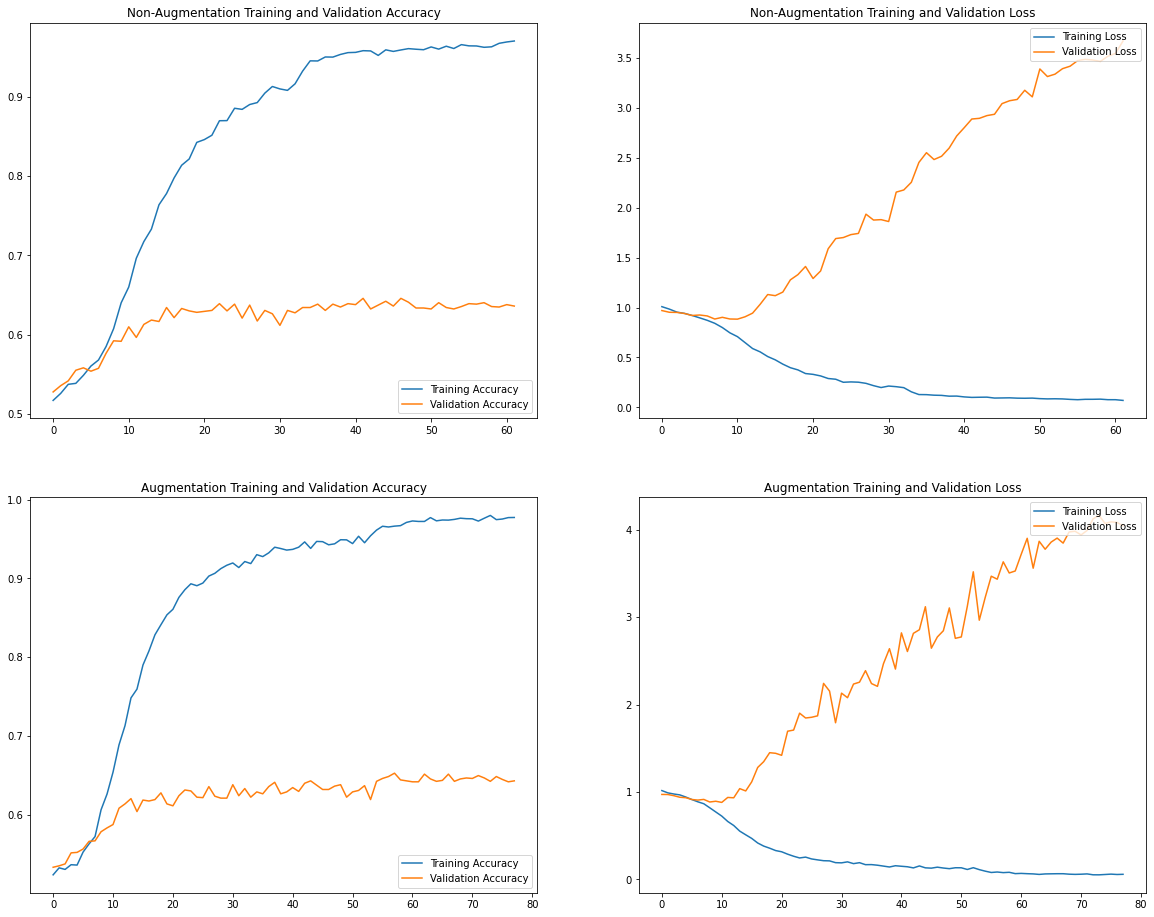

In [33]:
plt.figure(figsize=(20, 16))

plt.subplot(2, 2, 1)
plt.plot(history_cnnv2.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnnv2.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Non-Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(history_cnnv2.history['loss'], label='Training Loss')
plt.plot(history_cnnv2.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Non-Augmentation Training and Validation Loss')

plt.subplot(2, 2, 3)
plt.plot(history_cnnv2_ag.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnnv2_ag.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 4)
plt.plot(history_cnnv2_ag.history['loss'], label='Training Loss')
plt.plot(history_cnnv2_ag.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Augmentation Training and Validation Loss')

plt.show()

## **MobileNet V1**

In [14]:
class Depthwise_bn_relu(tf.keras.Model):
    def __init__(self, strides, padding):
        super(Depthwise_bn_relu, self).__init__()

        self.strides = strides
        self.padding = padding

        self.dw = tf.keras.layers.DepthwiseConv2D(kernel_size=(3, 3), 
                                                  strides=self.strides, 
                                                  padding=self.padding,
                                                  use_bias=False)
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()

    def call(self, x, training=False):
        x = self.dw(x)
        x = self.bn(x)
        x = self.relu(x)

        return x



class Pointwise_bn_relu(tf.keras.Model):
    def __init__(self, nb_filters):
        super(Pointwise_bn_relu, self).__init__()

        self.nb_filters = nb_filters

        self.pw = tf.keras.layers.Conv2D(self.nb_filters,
                                         kernel_size=(1, 1), 
                                         strides=(1, 1),  
                                         padding='same', 
                                         use_bias=False)
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()

    def call(self, x, training=False):
        x = self.pw(x)
        x = self.bn(x)
        x = self.relu(x)

        return x


    


class MobilenetV1(tf.keras.Model):
    def __init__(self, nb_class):
        super(MobilenetV1, self).__init__()

        self.nb_class = nb_class
        self.zero_pad = tf.keras.layers.ZeroPadding2D((2, 2))
        self.conv = tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), use_bias=False)
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()

        self.block1 = tf.keras.Sequential()
        self.block1.add(Depthwise_bn_relu(1, 'same'))
        self.block1.add(Pointwise_bn_relu(64))
        self.zero_pad_1 = tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1)))
        
        
        self.block2 = tf.keras.Sequential()
        self.block2.add(Depthwise_bn_relu(2, 'valid'))
        self.block2.add(Pointwise_bn_relu(128))
        self.block2.add(Depthwise_bn_relu(1, 'same'))
        self.block2.add(Pointwise_bn_relu(128))
        self.zero_pad_2 = tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1)))


        self.block3 = tf.keras.Sequential()
        self.block3.add(Depthwise_bn_relu(2, 'valid'))
        self.block3.add(Pointwise_bn_relu(256))
        self.block3.add(Depthwise_bn_relu(1, 'same'))
        self.block3.add(Pointwise_bn_relu(256))
        self.zero_pad_3 = tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1)))


        self.block4 = tf.keras.Sequential()
        self.block4.add(Depthwise_bn_relu(2, 'valid'))
        self.block4.add(Pointwise_bn_relu(512))

        for _ in range(5):
            self.block4.add(Depthwise_bn_relu(1, 'same'))
            self.block4.add(Pointwise_bn_relu(512))

        self.zero_pad_4 = tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1)))



        self.block5 = tf.keras.Sequential()
        self.block5.add(Depthwise_bn_relu(2, 'valid'))
        self.block5.add(Pointwise_bn_relu(1024))
        self.block5.add(Depthwise_bn_relu(2, 'same'))
        self.block5.add(Pointwise_bn_relu(1024))


        self.gap = tf.keras.layers.GlobalAveragePooling2D()
        self.reshape = tf.keras.layers.Reshape((1, 1, 1024))
        self.drop = tf.keras.layers.Dropout(0.001)
        self.conv_pred = tf.keras.layers.Conv2D(1000, 
                                                kernel_size=(1, 1), 
                                                strides=(1, 1), 
                                                padding='same', 
                                                activation='softmax')
        self.reshape_2 = tf.keras.layers.Reshape((1000,))

        


    def call(self, x, training=False):
        x = self.zero_pad(x)
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
       
        x = self.block1(x)
        x = self.zero_pad_1(x)

        x = self.block2(x)
        x = self.zero_pad_2(x)

        x = self.block3(x)
        x = self.zero_pad_3(x)

        x = self.block4(x)
        x = self.zero_pad_4(x)

        x = self.block5(x)

        x = self.gap(x)
        x = self.reshape(x)
        x = self.drop(x)
        x = self.conv_pred(x)
        x = self.reshape_2(x)
        
        return x

    

### 1. Non Augmentation Model

In [14]:
mov1 = MobilenetV1(1000)
mov1.build((1, 128, 128, 3))
mov1.summary()

Model: "mobilenet_v1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 multiple                  0         
_________________________________________________________________
conv2d (Conv2D)              multiple                  864       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
re_lu (ReLU)                 multiple                  0         
_________________________________________________________________
sequential (Sequential)      (1, 65, 65, 64)           2720      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin multiple                  0         
_________________________________________________________________
sequential_1 (Sequential)    (1, 32, 32, 128)         

In [35]:
mov1.compile(
    optimizer = 'adam'
    ,loss = 'sparse_categorical_crossentropy'
    ,metrics = ['accuracy']
)

In [36]:
# initialize callbacks
reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose=1, mode='max', restore_best_weights= True)

checkpoint = ModelCheckpoint('mov1.weights.ckpt', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [37]:
# train model

# Non-augmentation
train_gen = ImageDataGenerator().flow(X_train, y_train, batch_size = BATCH_SIZE)
valid_gen = ImageDataGenerator().flow(X_valid, y_valid, batch_size = BATCH_SIZE)

history_mov1 = mov1.fit(
    train_gen
    , steps_per_epoch = TRAIN_STEPS
    , validation_data = valid_gen
    , epochs = 100
    , callbacks = [reduceLR, early_stopping, checkpoint]
)

Epoch 1/100
410/410 [==============================] - 17s 34ms/step - loss: 1.1267 - accuracy: 0.4961 - val_loss: 1.0736 - val_accuracy: 0.2952

Epoch 00001: val_accuracy improved from -inf to 0.29519, saving model to mov1.weights.ckpt


2022-11-27 04:02:39.388514: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/100
410/410 [==============================] - 13s 33ms/step - loss: 0.9982 - accuracy: 0.5228 - val_loss: 0.9727 - val_accuracy: 0.5326

Epoch 00002: val_accuracy improved from 0.29519 to 0.53256, saving model to mov1.weights.ckpt
Epoch 3/100
410/410 [==============================] - 14s 33ms/step - loss: 0.9674 - accuracy: 0.5286 - val_loss: 1.0801 - val_accuracy: 0.4699

Epoch 00003: val_accuracy did not improve from 0.53256
Epoch 4/100
410/410 [==============================] - 13s 32ms/step - loss: 0.9469 - accuracy: 0.5266 - val_loss: 0.9712 - val_accuracy: 0.5393

Epoch 00004: val_accuracy improved from 0.53256 to 0.53926, saving model to mov1.weights.ckpt
Epoch 5/100
410/410 [==============================] - 14s 33ms/step - loss: 0.9329 - accuracy: 0.5361 - val_loss: 1.0221 - val_accuracy: 0.4808

Epoch 00005: val_accuracy did not improve from 0.53926
Epoch 6/100
410/410 [==============================] - 13s 32ms/step - loss: 0.9236 - accuracy: 0.5507 - val_loss: 1.0

In [38]:
mov1.save('mov1',save_format='tf')

In [39]:
np.save('mov1_hist.npy', history_mov1.history)

-------여기서 터짐---------

In [12]:
# load model
mov1 = keras.models.load_model('/kaggle/working/mov1')
mov1.compile(
    optimizer = 'adam'
    ,loss = 'sparse_categorical_crossentropy'
    ,metrics = ['accuracy']
)

2022-11-27 04:44:46.204211: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 04:44:46.302105: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 04:44:46.302955: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 04:44:46.304890: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [13]:
# confusion matrix
y_pred_enc = mov1.predict(X_valid)          # one-hot encoding된 label 예측값
y_pred = [np.argmax(i) for i in y_pred_enc] # label 예측값

item = {
      0: 'Type 1'
    , 1: 'Type 2'
    , 2: 'Type 3'
}

matrix = confusion_matrix(y_valid, y_pred)
df = pd.DataFrame(matrix)
df.columns = item.values()
df.index = item.values()
        
df

2022-11-27 04:45:07.550249: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-27 04:45:08.935676: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


,Type 1,Type 2,Type 3
Type 1,139,108,41
Type 2,66,677,127
Type 3,29,202,254


### 2. Augmentation Model

In [15]:
mov1_ag = MobilenetV1(1000)
mov1_ag.build((1,128,128,3))
mov1_ag.summary()

Model: "mobilenet_v1_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_5 (ZeroPaddin multiple                  0         
_________________________________________________________________
conv2d_15 (Conv2D)           multiple                  864       
_________________________________________________________________
batch_normalization_27 (Batc multiple                  128       
_________________________________________________________________
re_lu_27 (ReLU)              multiple                  0         
_________________________________________________________________
sequential_5 (Sequential)    (1, 65, 65, 64)           2720      
_________________________________________________________________
zero_padding2d_6 (ZeroPaddin multiple                  0         
_________________________________________________________________
sequential_6 (Sequential)    (1, 32, 32, 128)       

In [16]:
mov1_ag.compile(
    optimizer = 'adam'
    , loss = 'sparse_categorical_crossentropy'
    , metrics = ['accuracy']
)

In [20]:
#augmentation data

train_datagen = ImageDataGenerator(
                     rotation_range=20,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.1,
                     vertical_flip=True,
                     horizontal_flip=True,
                     fill_mode='nearest')


train_gen_ag = train_datagen.flow(X_train, y_train, batch_size = BATCH_SIZE)
valid_gen = ImageDataGenerator().flow(X_train, y_train, batch_size = BATCH_SIZE)

In [23]:
reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose= 1, mode='max', restore_best_weights= True)

checkpoint_ag = ModelCheckpoint('mov1_ag.weights.ckpt', monitor = 'val_accuracy', verbose = 1, save_best_only=True, mode= 'max')

In [24]:
history_mov1_ag = mov1_ag.fit(
    train_gen_ag
    , steps_per_epoch= TRAIN_STEPS
    , validation_data=valid_gen
    , validation_steps=VAL_STEPS
    , epochs= 100
    , callbacks= [reduceLR, early_stopping, checkpoint_ag]
)

Epoch 1/100
410/410 [==============================] - 34s 72ms/step - loss: 1.1434 - accuracy: 0.4862 - val_loss: 0.9958 - val_accuracy: 0.5472

Epoch 00001: val_accuracy improved from -inf to 0.54718, saving model to mov1_ag.weights.ckpt


2022-11-27 04:50:00.373051: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/100
410/410 [==============================] - 29s 71ms/step - loss: 1.0034 - accuracy: 0.5108 - val_loss: 1.0758 - val_accuracy: 0.5129

Epoch 00002: val_accuracy did not improve from 0.54718
Epoch 3/100
410/410 [==============================] - 29s 70ms/step - loss: 1.0005 - accuracy: 0.5066 - val_loss: 1.0633 - val_accuracy: 0.4651

Epoch 00003: val_accuracy did not improve from 0.54718
Epoch 4/100
410/410 [==============================] - 28s 69ms/step - loss: 0.9837 - accuracy: 0.5170 - val_loss: 1.0212 - val_accuracy: 0.4749

Epoch 00004: val_accuracy did not improve from 0.54718
Epoch 5/100
410/410 [==============================] - 29s 70ms/step - loss: 0.9583 - accuracy: 0.5213 - val_loss: 0.9414 - val_accuracy: 0.5055

Epoch 00005: val_accuracy did not improve from 0.54718
Epoch 6/100
410/410 [==============================] - 29s 70ms/step - loss: 0.9573 - accuracy: 0.5184 - val_loss: 0.9217 - val_accuracy: 0.5282

Epoch 00006: val_accuracy did not improve from 0.5

In [25]:
mov1_ag.save('mov1_ag',save_format='tf')
np.save('mov1_ag_hist.npy', history_mov1_ag.history)

In [34]:
#mov1_ag.save_weights('mov1_ag.h5') -> subclassed model의 save 방법 다름, 어떤거 선택할지 의논

In [26]:
# confusion matrix
y_pred_enc = mov1_ag.predict(X_valid)         
y_pred = [np.argmax(i) for i in y_pred_enc] 

item = {
      0: 'Type 1'
    , 1: 'Type 2'
    , 2: 'Type 3'
}

matrix = confusion_matrix(y_valid, y_pred)
df = pd.DataFrame(matrix)
df.columns = item.values()
df.index = item.values()
        
df

,Type 1,Type 2,Type 3
Type 1,183,63,42
Type 2,42,677,151
Type 3,23,136,326


### 3. Compare Models

In [29]:
history_mov1 = np.load('mov1_hist.npy', allow_pickle = 'TRUE').item()

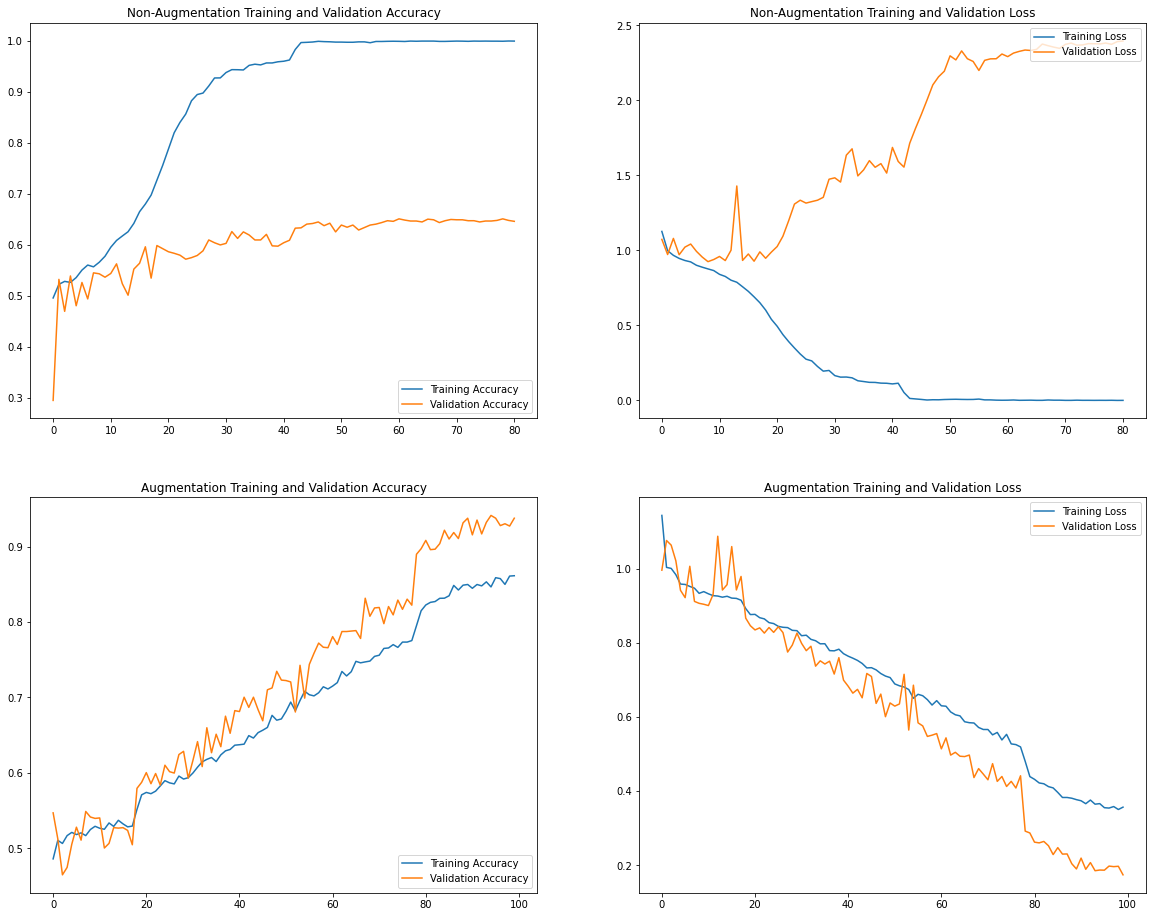

In [32]:
plt.figure(figsize=(20, 16))

plt.subplot(2, 2, 1)
plt.plot(history_mov1['accuracy'], label='Training Accuracy')
plt.plot(history_mov1['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Non-Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(history_mov1['loss'], label='Training Loss')
plt.plot(history_mov1['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Non-Augmentation Training and Validation Loss')

plt.subplot(2, 2, 3)
plt.plot(history_mov1_ag.history['accuracy'], label='Training Accuracy')
plt.plot(history_mov1_ag.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 4)
plt.plot(history_mov1_ag.history['loss'], label='Training Loss')
plt.plot(history_mov1_ag.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Augmentation Training and Validation Loss')

plt.show()

## **VGG16**

### 1. Non Augmentation Model

In [35]:
# Build base model (pre-trained)
base = VGG16(input_shape = (128, 128, 3)
                   , weights = 'imagenet'
                   , include_top = False)

58900480/58889256 [==============================] - 0s 0us/step


In [36]:
# show trainable layers before freezing
print('This is the number of trainable weights '
'before freezing layers in the conv base:', len(base.trainable_weights))

This is the number of trainable weights before freezing layers in the conv base: 26


In [37]:
# do not train all layers (freezing few layers of pretrained model)
for layer in base.layers[:-3]:
    layer.trainable = False

In [38]:
# show trainable layers after freezing
print('This is the number of trainable weights '
'after freezing layers in the conv base:', len(base.trainable_weights))

This is the number of trainable weights after freezing layers in the conv base: 4


In [39]:
vgg16 = Sequential([
                    base
                    , Flatten()
                    , Dense(256, activation = 'relu')
                    , Dropout(0.5)
                    , Dense(3, activation = 'softmax')
])

vgg16.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 16,812,867
Trainable params: 6,817,795
Non-trainable params: 9,995,072
_________________________________________________________________


In [40]:
vgg16.compile(
    optimizer = Adam(0.0001)
    , loss = 'sparse_categorical_crossentropy'
    , metrics = ['accuracy']
)

In [41]:
# initialize callbacks
checkpoint = ModelCheckpoint('vgg16.weights.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [42]:
# train model

# Non-augmentation
train_gen = ImageDataGenerator().flow(X_train, y_train, batch_size = BATCH_SIZE)
valid_gen = ImageDataGenerator().flow(X_valid, y_valid, batch_size = BATCH_SIZE)

history_vgg16 = vgg16.fit(
    train_gen
    , steps_per_epoch = TRAIN_STEPS
    , validation_data = valid_gen
    , epochs = 100
    , callbacks = [reduceLR, early_stopping, checkpoint]
)

Epoch 1/100
410/410 [==============================] - 11s 23ms/step - loss: 0.9868 - accuracy: 0.5222 - val_loss: 0.9099 - val_accuracy: 0.5606

Epoch 00001: val_accuracy improved from -inf to 0.56056, saving model to vgg16.weights.hdf5
Epoch 2/100
410/410 [==============================] - 9s 21ms/step - loss: 0.8843 - accuracy: 0.5778 - val_loss: 0.8574 - val_accuracy: 0.5965

Epoch 00002: val_accuracy improved from 0.56056 to 0.59647, saving model to vgg16.weights.hdf5
Epoch 3/100
410/410 [==============================] - 9s 21ms/step - loss: 0.7908 - accuracy: 0.6283 - val_loss: 0.8324 - val_accuracy: 0.6336

Epoch 00003: val_accuracy improved from 0.59647 to 0.63360, saving model to vgg16.weights.hdf5
Epoch 4/100
410/410 [==============================] - 9s 21ms/step - loss: 0.6729 - accuracy: 0.6956 - val_loss: 0.7887 - val_accuracy: 0.6476

Epoch 00004: val_accuracy improved from 0.63360 to 0.64760, saving model to vgg16.weights.hdf5
Epoch 5/100
410/410 [=====================

In [43]:
# save model, history (recall -> keras.models.load_model('') -> compile)
vgg16.save('vgg16.h5')
np.save('vgg16_hist.npy',history_vgg16.history)

In [44]:
# confusion matrix

y_pred_enc = vgg16.predict(X_valid)
y_pred = [np.argmax(i) for i in y_pred_enc]

item = {
      0: 'Type 1'
    , 1: 'Type 2'
    , 2: 'Type 3'
}

matrix = confusion_matrix(y_valid, y_pred)
df = pd.DataFrame(matrix)
df.columns = item.values()
df.index = item.values()
        
df

,Type 1,Type 2,Type 3
Type 1,168,79,41
Type 2,21,741,108
Type 3,17,147,321


### 2. Augmentation Model

In [46]:
vgg16_ag = Sequential([
                    base
                    , Flatten()
                    , Dense(256, activation = 'relu')
                    , Dropout(0.5)
                    , Dense(3, activation = 'softmax')
])

vgg16_ag.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 771       
Total params: 16,812,867
Trainable params: 6,817,795
Non-trainable params: 9,995,072
_________________________________________________________________


In [47]:
vgg16_ag.compile(
    optimizer = Adam(0.0001)
    , loss = 'sparse_categorical_crossentropy'
    , metrics = ['accuracy']
)

In [48]:
# augmentation
train_datagen = ImageDataGenerator(
                                rotation_range = 40,
                                zoom_range = 0.2,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                horizontal_flip = True,
                                vertical_flip = True)

train_gen_ag = train_datagen.flow(X_train, y_train, batch_size= BATCH_SIZE)
valid_gen = ImageDataGenerator().flow(X_valid, y_valid, batch_size = BATCH_SIZE)

In [49]:
# initialize callbacks
reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)
early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose=1, mode='max', restore_best_weights= True)

checkpoint_ag = ModelCheckpoint('vgg16_ag.weights.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [50]:
history_vgg16_ag = vgg16_ag.fit(
    train_gen_ag
    , steps_per_epoch= TRAIN_STEPS
    , validation_data=valid_gen
    , validation_steps=VAL_STEPS
    , epochs= 100
    , callbacks= [reduceLR, early_stopping, checkpoint_ag]
)

Epoch 1/100
410/410 [==============================] - 30s 72ms/step - loss: 0.9559 - accuracy: 0.5414 - val_loss: 0.8232 - val_accuracy: 0.6244

Epoch 00001: val_accuracy improved from -inf to 0.62439, saving model to vgg_ag.weights.hdf5
Epoch 2/100
410/410 [==============================] - 27s 66ms/step - loss: 0.9030 - accuracy: 0.5698 - val_loss: 0.8179 - val_accuracy: 0.6262

Epoch 00002: val_accuracy improved from 0.62439 to 0.62623, saving model to vgg_ag.weights.hdf5
Epoch 3/100
410/410 [==============================] - 28s 67ms/step - loss: 0.8821 - accuracy: 0.5704 - val_loss: 0.7908 - val_accuracy: 0.6311

Epoch 00003: val_accuracy improved from 0.62623 to 0.63113, saving model to vgg_ag.weights.hdf5
Epoch 4/100
410/410 [==============================] - 28s 69ms/step - loss: 0.8652 - accuracy: 0.5958 - val_loss: 0.8008 - val_accuracy: 0.6158

Epoch 00004: val_accuracy did not improve from 0.63113
Epoch 5/100
410/410 [==============================] - 29s 70ms/step - loss:

In [51]:
# save model (recall -> keras.models.load_model('') -> compile)
vgg16_ag.save('vgg16_ag.h5')
np.save('vgg16_ag_hist.npy', history_vgg16_ag.history)

----------여기서 터짐-----------

In [16]:
# recall model
history_vgg16 = np.load('vgg16_hist.npy', allow_pickle = 'TRUE').item()

vgg16_ag = keras.models.load_model('vgg16_ag.h5')
vgg16_ag.compile(optimizer=Adam(0.0001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history_vgg16_ag = np.load('vgg16_ag_hist.npy', allow_pickle = 'TRUE').item()

In [15]:
# confusion matrix

y_pred_enc = vgg16_ag.predict(X_valid)
y_pred = [np.argmax(i) for i in y_pred_enc]

item = {
      0: 'Type 1'
    , 1: 'Type 2'
    , 2: 'Type 3'
}

matrix = confusion_matrix(y_valid, y_pred)
df = pd.DataFrame(matrix)
df.columns = item.values()
df.index = item.values()
        
df

2022-11-27 07:49:59.998537: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-27 07:50:00.987699: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


,Type 1,Type 2,Type 3
Type 1,181,73,34
Type 2,34,729,107
Type 3,21,140,324


### 3. Compare Models

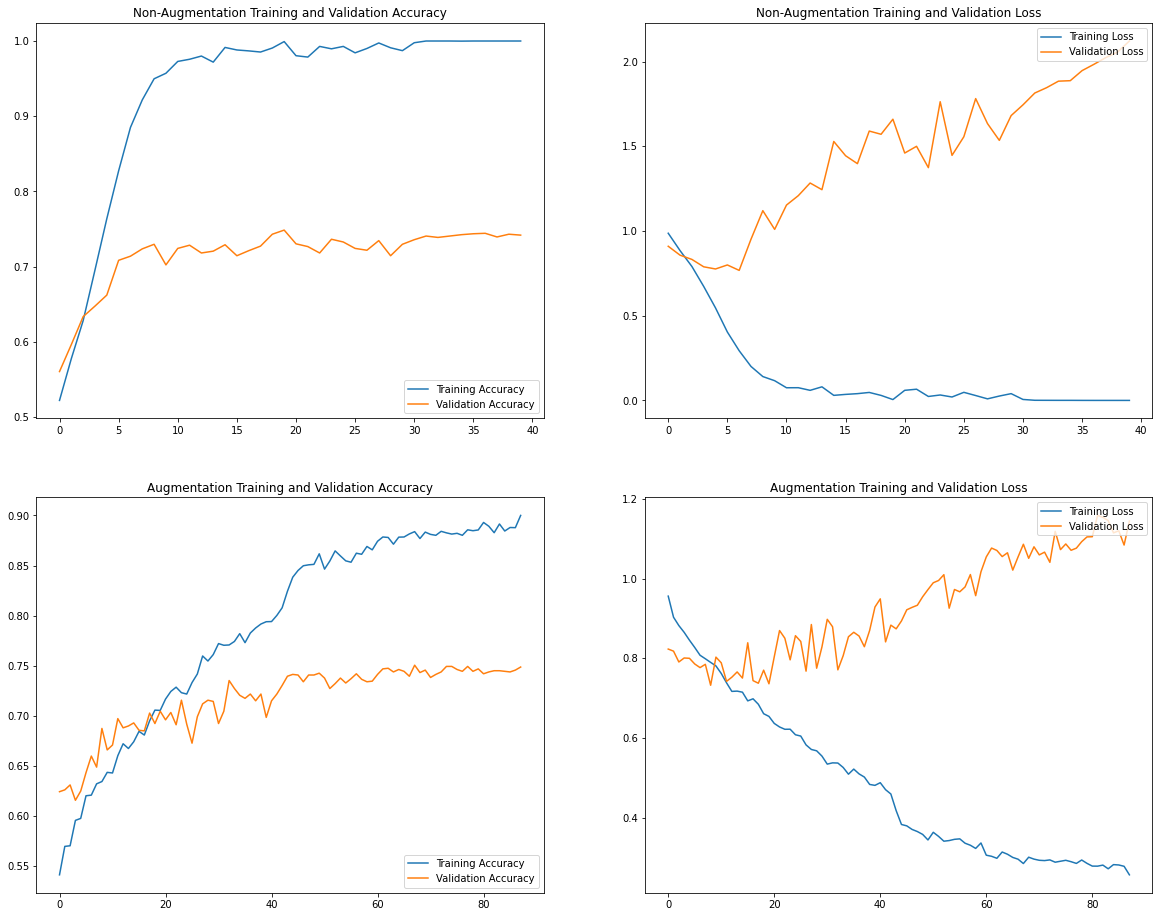

In [18]:
plt.figure(figsize=(20, 16))

plt.subplot(2, 2, 1)
plt.plot(history_vgg16['accuracy'], label='Training Accuracy')
plt.plot(history_vgg16['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Non-Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(history_vgg16['loss'], label='Training Loss')
plt.plot(history_vgg16['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Non-Augmentation Training and Validation Loss')

plt.subplot(2, 2, 3)
plt.plot(history_vgg16_ag['accuracy'], label='Training Accuracy')
plt.plot(history_vgg16_ag['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 4)
plt.plot(history_vgg16_ag['loss'], label='Training Loss')
plt.plot(history_vgg16_ag['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Augmentation Training and Validation Loss')

plt.show()

## **VGG 19**

In [ ]:
'''
#nongen
k = ImageDataGenerator(rescale=1./ 255, validation_split=0.2)
t_nongen = k.flow_from_dataframe(files_df, x_col='filepath', y_col='label', target_size = (128, 128), class_mode='categorical', color_mode='rgb', subset='training')
v_nongen = k.flow_from_dataframe(files_df, x_col='filepath', y_col='label', target_size = (128, 128), class_mode='categorical', color_mode='rgb', subset='validation')
'''

In [ ]:
'''
t = ImageDataGenerator(rescale=1./ 255, 
                       rotation_range = 40,
                        zoom_range = 0.2,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        horizontal_flip = True,
                        vertical_flip = True)

#t = ImageDataGenerator(rescale=1./ 255, rotation_range=0.3, zoom_range=0.3)

t_gen = t.flow_from_dataframe(
    files_df
    ,x_col='filepath'
    , y_col='label'
    , target_size = (128, 128)
    ,batch_size=16
    ,class_mode='categorical'
    , color_mode='rgb'
    , subset='training'
)
'''

### 1. Non Augmentation model

In [19]:
# Non-augmentation
train_gen = ImageDataGenerator().flow(X_train, y_train, batch_size = BATCH_SIZE)
valid_gen = ImageDataGenerator().flow(X_valid, y_valid, batch_size = BATCH_SIZE)

In [20]:
# initialize callbacks
reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose=1, mode='max', restore_best_weights= True)

checkpoint = ModelCheckpoint('vgg19.weights.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [24]:
# 사전 교육된 기본 모델 가져오기
base_model = VGG19(include_top=False, weights='imagenet',input_shape=(128, 128, 3))

base_model.trainable = False

# 교육할 계층 설정 최상위 계층만 교육하기 위해 (False 가중치 고정)
for layer in base_model.layers:
    layer.trainable = False
    
# 기본 모델의 마지막 층
x = base_model.output

x = Flatten()(x)
h1 = Dense(512, activation='relu')(x)
drop1 = Dropout(rate=0.5)(h1)
h2 = Dense(512, activation='relu')(drop1)
drop2 = Dropout(rate=0.5)(h2)
output = Dense(3, activation='softmax')(drop2)

vgg19 = keras.Model(inputs=base_model.input, outputs=output)
vgg19.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [25]:
vgg19.compile(
    optimizer = Adam(0.0001)
    , loss = 'sparse_categorical_crossentropy'
    , metrics = ['accuracy']
)

In [26]:
history_vgg19 = vgg19.fit(
    train_gen
    , steps_per_epoch = TRAIN_STEPS
    , validation_data= valid_gen
    , epochs= EPOCHS
    , verbose=1
    , callbacks = [reduceLR, early_stopping, checkpoint]
)

Epoch 1/100
410/410 [==============================] - 11s 23ms/step - loss: 1.0560 - accuracy: 0.4918 - val_loss: 0.9715 - val_accuracy: 0.5423

Epoch 00001: val_accuracy improved from -inf to 0.54230, saving model to vgg19.weights.hdf5
Epoch 2/100
410/410 [==============================] - 9s 22ms/step - loss: 0.9940 - accuracy: 0.5155 - val_loss: 0.9453 - val_accuracy: 0.5356

Epoch 00002: val_accuracy did not improve from 0.54230
Epoch 3/100
410/410 [==============================] - 9s 22ms/step - loss: 0.9695 - accuracy: 0.5295 - val_loss: 0.9439 - val_accuracy: 0.5399

Epoch 00003: val_accuracy did not improve from 0.54230
Epoch 4/100
410/410 [==============================] - 9s 23ms/step - loss: 0.9496 - accuracy: 0.5277 - val_loss: 0.9241 - val_accuracy: 0.5514

Epoch 00004: val_accuracy improved from 0.54230 to 0.55143, saving model to vgg19.weights.hdf5
Epoch 5/100
410/410 [==============================] - 9s 22ms/step - loss: 0.9203 - accuracy: 0.5442 - val_loss: 0.9105 -

In [27]:
# save model (recall -> keras.models.load_model('') -> compile)
vgg19.save('vgg19.h5')
np.save('vgg19_hist.npy', history_vgg19.history)

In [28]:
# confusion matrix
y_pred_enc = vgg19.predict(X_valid)        
y_pred = [np.argmax(i) for i in y_pred_enc]
item = {
      0: 'Type 1'
    , 1: 'Type 2'
    , 2: 'Type 3'
}

matrix = confusion_matrix(y_valid, y_pred)
df = pd.DataFrame(matrix)
df.columns = item.values()
df.index = item.values()
        
df

,Type 1,Type 2,Type 3
Type 1,134,120,34
Type 2,19,742,109
Type 3,12,197,276


### 2. Augmentation Model

In [34]:
train_datagen = ImageDataGenerator(
                                rotation_range = 40,
                                zoom_range = 0.2,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                horizontal_flip = True,
                                vertical_flip = True)

train_gen_ag = train_datagen.flow(X_train, y_train, batch_size= BATCH_SIZE)

In [35]:
# initialize callbacks
reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose=1, mode='max', restore_best_weights= True)

checkpoint_ag = ModelCheckpoint('vgg19_ag.weights.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [36]:
# 사전 교육된 기본 모델 가져오기
base_model = VGG19(include_top=False, weights='imagenet',input_shape=(128, 128, 3))

base_model.trainable = False

# 교육할 계층 설정 최상위 계층만 교육하기 위해 (False 가중치 고정)
for layer in base_model.layers:
    layer.trainable = False
    
# 기본 모델의 마지막 층
x = base_model.output

x = Flatten()(x)
h1 = Dense(512, activation='relu')(x)
drop1 = Dropout(rate=0.5)(h1)
h2 = Dense(512, activation='relu')(drop1)
drop2 = Dropout(rate=0.5)(h2)
output = Dense(3, activation='softmax')(drop2)

vgg19_ag = keras.Model(inputs=base_model.input, outputs=output)
vgg19_ag.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [37]:
vgg19_ag.compile(
    optimizer = Adam(0.0001)
    , loss = 'sparse_categorical_crossentropy'
    , metrics = ['accuracy']
)

In [39]:
history_vgg19_ag = vgg19_ag.fit(
    train_gen_ag
    , steps_per_epoch = TRAIN_STEPS
    , validation_data= valid_gen
    , validation_steps = VAL_STEPS
    , epochs= EPOCHS
    , verbose=1
    , callbacks = [reduceLR, early_stopping, checkpoint_ag]
)

Epoch 1/100
410/410 [==============================] - 29s 70ms/step - loss: 1.0800 - accuracy: 0.4816 - val_loss: 0.9937 - val_accuracy: 0.5312

Epoch 00001: val_accuracy improved from -inf to 0.53125, saving model to vgg19_ag.weights.hdf5
Epoch 2/100
410/410 [==============================] - 28s 68ms/step - loss: 1.0166 - accuracy: 0.5105 - val_loss: 0.9841 - val_accuracy: 0.5300

Epoch 00002: val_accuracy did not improve from 0.53125
Epoch 3/100
410/410 [==============================] - 28s 67ms/step - loss: 1.0099 - accuracy: 0.5172 - val_loss: 0.9785 - val_accuracy: 0.5312

Epoch 00003: val_accuracy did not improve from 0.53125
Epoch 4/100
410/410 [==============================] - 29s 70ms/step - loss: 0.9992 - accuracy: 0.5231 - val_loss: 0.9626 - val_accuracy: 0.5325

Epoch 00004: val_accuracy improved from 0.53125 to 0.53248, saving model to vgg19_ag.weights.hdf5
Epoch 5/100
410/410 [==============================] - 29s 71ms/step - loss: 0.9971 - accuracy: 0.5190 - val_loss

In [40]:
# save model (recall -> keras.models.load_model('') -> compile)
vgg19_ag.save('vgg19_ag.h5')
np.save('vgg19_ag_hist.npy', history_vgg19_ag.history)

In [41]:
# confusion matrix
y_pred_enc = vgg19_ag.predict(X_valid)        
y_pred = [np.argmax(i) for i in y_pred_enc]
item = {
      0: 'Type 1'
    , 1: 'Type 2'
    , 2: 'Type 3'
}

matrix = confusion_matrix(y_valid, y_pred)
df = pd.DataFrame(matrix)
df.columns = item.values()
df.index = item.values()
        
df

,Type 1,Type 2,Type 3
Type 1,0,281,7
Type 2,0,804,66
Type 3,0,376,109


### 3. Compare Models

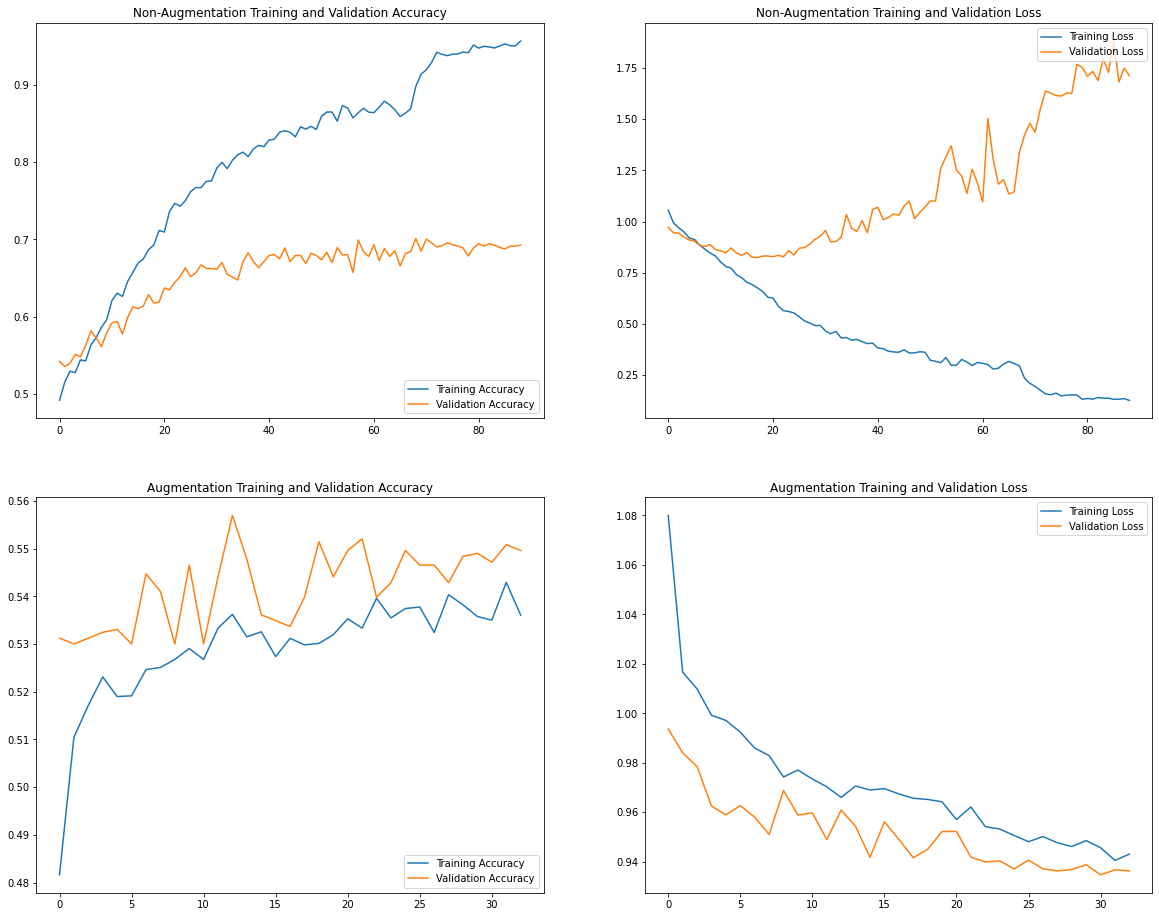

In [42]:
plt.figure(figsize=(20, 16))

plt.subplot(2, 2, 1)
plt.plot(history_vgg19.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg19.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Non-Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(history_vgg19.history['loss'], label='Training Loss')
plt.plot(history_vgg19.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Non-Augmentation Training and Validation Loss')

plt.subplot(2, 2, 3)
plt.plot(history_vgg19_ag.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg19_ag.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 4)
plt.plot(history_vgg19_ag.history['loss'], label='Training Loss')
plt.plot(history_vgg19_ag.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Augmentation Training and Validation Loss')

plt.show()

## **ResNet18**

In [16]:
# non-augmentation
train_gen_non = ImageDataGenerator().flow(X_train, y_train_onehot, batch_size = BATCH_SIZE)
valid_gen_non = ImageDataGenerator().flow(X_valid, y_valid_onehot, batch_size = BATCH_SIZE)

# augmentation
train_datagen = ImageDataGenerator(
                                rotation_range = 40,
                                zoom_range = 0.2,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                horizontal_flip = True,
                                vertical_flip = True)

train_gen = train_datagen.flow(X_train, y_train_onehot, batch_size= BATCH_SIZE)
val_gen = ImageDataGenerator().flow(X_valid, y_valid_onehot, batch_size= BATCH_SIZE)

In [17]:
# initialize callbacks
reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose=1, mode='max', restore_best_weights= True)

checkpoint = ModelCheckpoint('resnet18.weights.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

checkpoint_ag = ModelCheckpoint('resnet18_ag.weights.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [18]:
def identity_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='SAME')(X)
    
    return X

def convolutional_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    return X

def resnet18(input_shape = (128, 128, 3), classes = 10):
    X_input = tf.keras.layers.Input(input_shape)
    X = X_input
    
    X = convolutional_block(X, 64, (3,3)) #conv
    X = identity_block(X, 64, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 128, (3,3)) #64->128, use conv block
    X = identity_block(X, 128, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 256, (3,3)) #128->256, use conv block
    X = identity_block(X, 256, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 512, (3,3)) #256->512, use conv block
    X = identity_block(X, 512, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = tf.keras.layers.GlobalAveragePooling2D()(X)
    X = tf.keras.layers.Dense(3, activation = 'softmax')(X) # ouput layer (3class)
    
    model = tf.keras.models.Model(inputs = X_input, outputs = X, name = "resnet18")
    
    return model

### 1. Non Augmentation Model

In [46]:
resnet18 = resnet18()
resnet18.compile(optimizer='adam'
                 , loss = 'categorical_crossentropy'
                 , metrics=['accuracy'])
resnet18.summary()

Model: "resnet18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      369

In [47]:
history_resnet18 = resnet18.fit(
    train_gen_non
    , steps_per_epoch = TRAIN_STEPS
    , validation_data = valid_gen_non
    , epochs = EPOCHS
    , batch_size = BATCH_SIZE
    , callbacks = [reduceLR, early_stopping, checkpoint]
)

Epoch 1/100
410/410 [==============================] - 31s 68ms/step - loss: 1.0736 - accuracy: 0.4879 - val_loss: 1.0793 - val_accuracy: 0.4011

Epoch 00001: val_accuracy improved from -inf to 0.40110, saving model to resnet18.weights.hdf5
Epoch 2/100
410/410 [==============================] - 27s 66ms/step - loss: 1.0197 - accuracy: 0.4941 - val_loss: 1.0278 - val_accuracy: 0.4041

Epoch 00002: val_accuracy improved from 0.40110 to 0.40414, saving model to resnet18.weights.hdf5
Epoch 3/100
410/410 [==============================] - 27s 66ms/step - loss: 1.0066 - accuracy: 0.5059 - val_loss: 1.0852 - val_accuracy: 0.5295

Epoch 00003: val_accuracy improved from 0.40414 to 0.52952, saving model to resnet18.weights.hdf5
Epoch 4/100
410/410 [==============================] - 27s 66ms/step - loss: 1.0000 - accuracy: 0.5050 - val_loss: 1.2265 - val_accuracy: 0.5295

Epoch 00004: val_accuracy did not improve from 0.52952
Epoch 5/100
410/410 [==============================] - 27s 66ms/step -

In [48]:
# save model
resnet18.save('resnet18.h5')
np.save('resnet18_hist.npy',history_resnet18.history) #history=np.load('my_history.npy',allow_pickle='TRUE').item()

------------여기서 터짐---------------

In [25]:
# load model
resnet18 = keras.models.load_model('resnet18.h5')
resnet18.compile(
    optimizer = 'adam'
    ,loss = 'categorical_crossentropy'
    ,metrics = ['accuracy']
)
history_resnet18 = np.load('resnet18_hist.npy',allow_pickle = 'TRUE').item()

In [14]:
# confusion matrix

y_pred_enc = resnet18.predict(X_valid)        
y_pred = [np.argmax(i) for i in y_pred_enc]

item = {
      0: 'Type 1'
    , 1: 'Type 2'
    , 2: 'Type 3'
}

matrix = confusion_matrix(y_valid, y_pred)
df = pd.DataFrame(matrix)
df.columns = item.values()
df.index = item.values()
        
df

2022-11-27 09:37:01.552717: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-27 09:37:02.704726: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


,Type 1,Type 2,Type 3
Type 1,159,79,50
Type 2,88,644,138
Type 3,28,171,286


### 2. Augmentation Model

In [19]:
resnet18_ag = resnet18()
resnet18_ag.compile(optimizer='adam'
                 , loss = 'categorical_crossentropy'
                 , metrics=['accuracy'])
resnet18_ag.summary()

Model: "resnet18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      369

In [20]:
history_resnet18_ag = resnet18_ag.fit(train_gen, 
                 steps_per_epoch= TRAIN_STEPS,
                 validation_data=val_gen, 
                 epochs=EPOCHS, 
                 batch_size=BATCH_SIZE, 
                 callbacks= [reduceLR, early_stopping, checkpoint_ag])

Epoch 1/100
410/410 [==============================] - 41s 95ms/step - loss: 1.0849 - accuracy: 0.4911 - val_loss: 1.1038 - val_accuracy: 0.5295

Epoch 00001: val_accuracy improved from -inf to 0.52952, saving model to resnet18_ag.weights.hdf5
Epoch 2/100
410/410 [==============================] - 34s 83ms/step - loss: 1.0675 - accuracy: 0.4848 - val_loss: 1.2119 - val_accuracy: 0.3530

Epoch 00002: val_accuracy did not improve from 0.52952
Epoch 3/100
410/410 [==============================] - 35s 84ms/step - loss: 1.0382 - accuracy: 0.4900 - val_loss: 1.1266 - val_accuracy: 0.5295

Epoch 00003: val_accuracy did not improve from 0.52952
Epoch 4/100
410/410 [==============================] - 34s 83ms/step - loss: 1.0314 - accuracy: 0.4920 - val_loss: 1.1399 - val_accuracy: 0.2775

Epoch 00004: val_accuracy did not improve from 0.52952
Epoch 5/100
410/410 [==============================] - 34s 84ms/step - loss: 1.0231 - accuracy: 0.5002 - val_loss: 1.7019 - val_accuracy: 0.1753

Epoch 0

In [21]:
# save model
resnet18_ag.save('resnet18_ag.h5')
np.save('resnet18_ag_hist.npy', history_resnet18_ag.history)

In [22]:
# confusion matrix

y_pred_enc = resnet18_ag.predict(X_valid)        
y_pred = [np.argmax(i) for i in y_pred_enc]

item = {
      0: 'Type 1'
    , 1: 'Type 2'
    , 2: 'Type 3'
}

matrix = confusion_matrix(y_valid, y_pred)
df = pd.DataFrame(matrix)
df.columns = item.values()
df.index = item.values()
        
df

,Type 1,Type 2,Type 3
Type 1,65,205,18
Type 2,47,716,107
Type 3,3,298,184


### 3. Compare Models

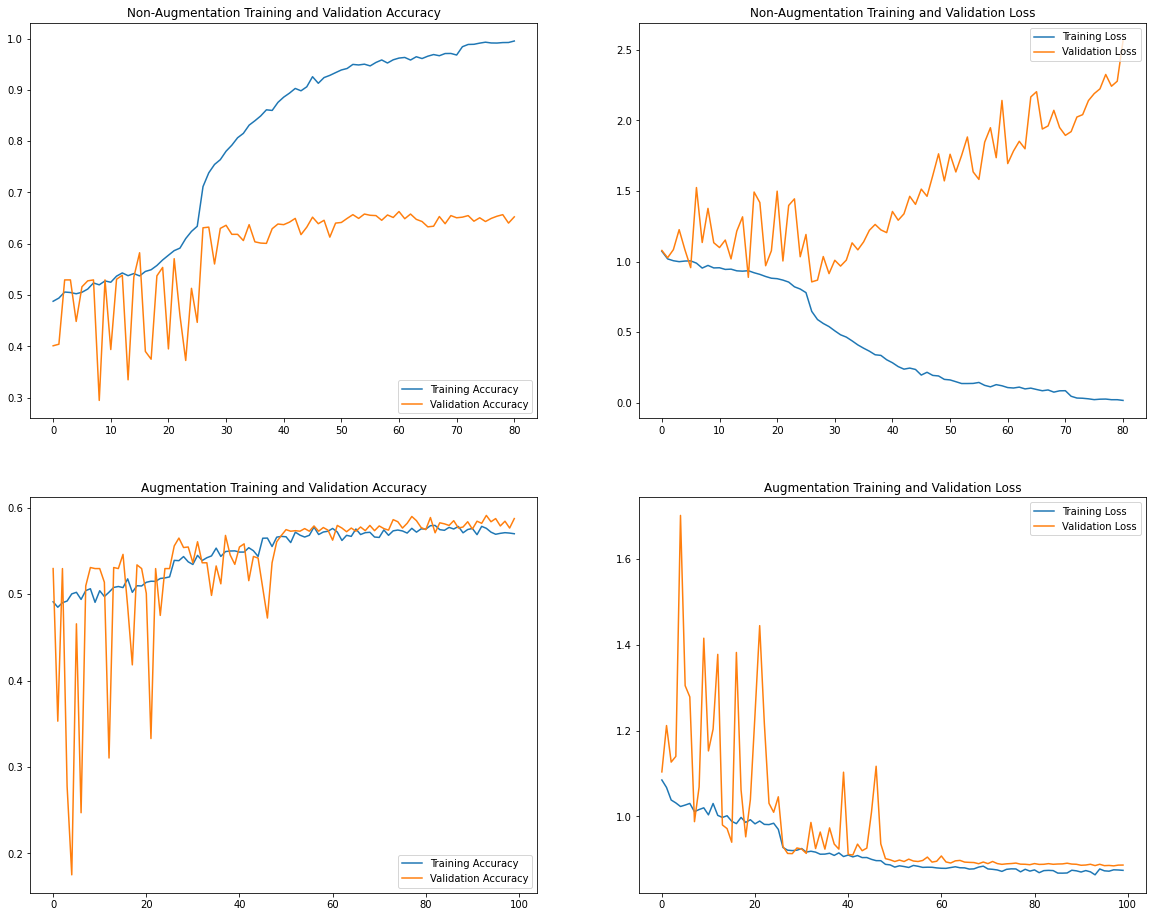

In [28]:
plt.figure(figsize=(20, 16))

plt.subplot(2, 2, 1)
plt.plot(history_resnet18['accuracy'], label='Training Accuracy')
plt.plot(history_resnet18['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Non-Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(history_resnet18['loss'], label='Training Loss')
plt.plot(history_resnet18['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Non-Augmentation Training and Validation Loss')

plt.subplot(2, 2, 3)
plt.plot(history_resnet18_ag.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet18_ag.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 4)
plt.plot(history_resnet18_ag.history['loss'], label='Training Loss')
plt.plot(history_resnet18_ag.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Augmentation Training and Validation Loss')

plt.show()

## **Resnet50 (pre-trained)**

### 1. Non Augmentation

In [29]:
resnet50 = Sequential([
    ResNet50(input_shape = (128,128,3) ,include_top = False, pooling = 'avg')
    , Flatten()
    , BatchNormalization()
    , Dense(512, activation = 'relu')
    , BatchNormalization()
    , Dense(256, activation = 'relu')
    , BatchNormalization()
    , Dense(3, activation = 'softmax')
])
resnet50.layers[0].trainable = False

resnet50.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
batch_normalization_21 (Batc (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________

In [30]:
resnet50.compile(
    optimizer = 'adam'
    , loss = 'sparse_categorical_crossentropy'
    , metrics = ['accuracy']
)

In [31]:
# initialize callbacks
reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose= 1, mode='max', restore_best_weights= True)

checkpoint = ModelCheckpoint('resnet50.weights.hdf5', monitor='val_accuracy', verbose= 1,save_best_only=True, mode= 'max')

In [32]:
# Non-augmentation
train_gen = ImageDataGenerator().flow(X_train, y_train, batch_size = BATCH_SIZE)
valid_gen = ImageDataGenerator().flow(X_valid, y_valid, batch_size = BATCH_SIZE)

history_resnet50 = resnet50.fit(
    train_gen
    , steps_per_epoch = TRAIN_STEPS
    , validation_data = valid_gen
    , epochs = 100
    , callbacks = [reduceLR, early_stopping, checkpoint]
)

Epoch 1/100
410/410 [==============================] - 15s 29ms/step - loss: 1.1053 - accuracy: 0.4902 - val_loss: 1.0412 - val_accuracy: 0.5295

Epoch 00001: val_accuracy improved from -inf to 0.52952, saving model to resnet50.weights.hdf5
Epoch 2/100
410/410 [==============================] - 11s 27ms/step - loss: 0.9788 - accuracy: 0.5199 - val_loss: 0.9940 - val_accuracy: 0.5295

Epoch 00002: val_accuracy did not improve from 0.52952
Epoch 3/100
410/410 [==============================] - 10s 26ms/step - loss: 0.9495 - accuracy: 0.5477 - val_loss: 1.0532 - val_accuracy: 0.5301

Epoch 00003: val_accuracy improved from 0.52952 to 0.53013, saving model to resnet50.weights.hdf5
Epoch 4/100
410/410 [==============================] - 11s 26ms/step - loss: 0.9330 - accuracy: 0.5555 - val_loss: 0.9926 - val_accuracy: 0.5362

Epoch 00004: val_accuracy improved from 0.53013 to 0.53621, saving model to resnet50.weights.hdf5
Epoch 5/100
410/410 [==============================] - 11s 26ms/step -

In [33]:
# save model (recall -> keras.models.load_model('') -> compile)
resnet50.save('resnet50.h5')
np.save('resnet50_hist.npy',history_resnet50.history)

In [34]:
y_pred_enc = resnet50.predict(X_valid)        
y_pred = [np.argmax(i) for i in y_pred_enc] 
item = {
      0: 'Type 1'
    , 1: 'Type 2'
    , 2: 'Type 3'
}

matrix = confusion_matrix(y_valid, y_pred)
df = pd.DataFrame(matrix)
df.columns = item.values()
df.index = item.values()
        
df

,Type 1,Type 2,Type 3
Type 1,136,106,46
Type 2,80,630,160
Type 3,48,181,256


### 2. Augmentation Model

In [35]:
resnet50_ag = Sequential([
    ResNet50(input_shape = (128,128,3) ,include_top = False, pooling = 'avg')
    , Flatten()
    , BatchNormalization()
    , Dense(512, activation = 'relu')
    , BatchNormalization()
    , Dense(256, activation = 'relu')
    , BatchNormalization()
    , Dense(3, activation = 'softmax')
])
resnet50_ag.layers[0].trainable = False

resnet50_ag.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1049088   
_________________________________________________________________
batch_normalization_24 (Batc (None, 512)               2048      
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_25 (Batc (None, 256)              

In [36]:
resnet50_ag.compile(
    optimizer = 'adam'
    , loss = 'sparse_categorical_crossentropy'
    , metrics = ['accuracy']
)

In [37]:
# initialize callbacks
checkpoint_ag = ModelCheckpoint('resnet50_ag.weights.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [38]:
# augmentation
train_datagen = ImageDataGenerator(
                                rotation_range = 40,
                                zoom_range = 0.2,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                horizontal_flip = True,
                                vertical_flip = True)

train_gen_ag = train_datagen.flow(X_train, y_train, batch_size= BATCH_SIZE)

history_resnet50_ag = resnet50_ag.fit(
    train_gen_ag
    , steps_per_epoch= TRAIN_STEPS
    , validation_data=valid_gen
    , validation_steps=VAL_STEPS
    , epochs= 100
    , callbacks= [reduceLR, early_stopping, checkpoint_ag]
)

Epoch 1/100
410/410 [==============================] - 37s 83ms/step - loss: 1.1606 - accuracy: 0.4624 - val_loss: 1.0105 - val_accuracy: 0.5300

Epoch 00001: val_accuracy improved from -inf to 0.53002, saving model to resnet50_ag.weights.hdf5
Epoch 2/100
410/410 [==============================] - 30s 73ms/step - loss: 1.0317 - accuracy: 0.5042 - val_loss: 1.0297 - val_accuracy: 0.4988

Epoch 00002: val_accuracy did not improve from 0.53002
Epoch 3/100
410/410 [==============================] - 30s 72ms/step - loss: 1.0206 - accuracy: 0.5100 - val_loss: 1.0142 - val_accuracy: 0.5263

Epoch 00003: val_accuracy did not improve from 0.53002
Epoch 4/100
410/410 [==============================] - 31s 75ms/step - loss: 1.0129 - accuracy: 0.5108 - val_loss: 1.0592 - val_accuracy: 0.4963

Epoch 00004: val_accuracy did not improve from 0.53002
Epoch 5/100
410/410 [==============================] - 30s 72ms/step - loss: 1.0139 - accuracy: 0.5134 - val_loss: 1.0563 - val_accuracy: 0.5098

Epoch 0

In [39]:
# save model (recall -> keras.models.load_model('') -> compile)
resnet50_ag.save('resnet50_ag.h5')
np.save('resnet50_ag_hist',history_resnet50_ag.history)

In [40]:
y_pred_enc = resnet50_ag.predict(X_valid)        
y_pred = [np.argmax(i) for i in y_pred_enc] 
item = {
      0: 'Type 1'
    , 1: 'Type 2'
    , 2: 'Type 3'
}

matrix = confusion_matrix(y_valid, y_pred)
df = pd.DataFrame(matrix)
df.columns = item.values()
df.index = item.values()
        
df

,Type 1,Type 2,Type 3
Type 1,1,259,28
Type 2,0,758,112
Type 3,1,366,118


### 3. Compare Models

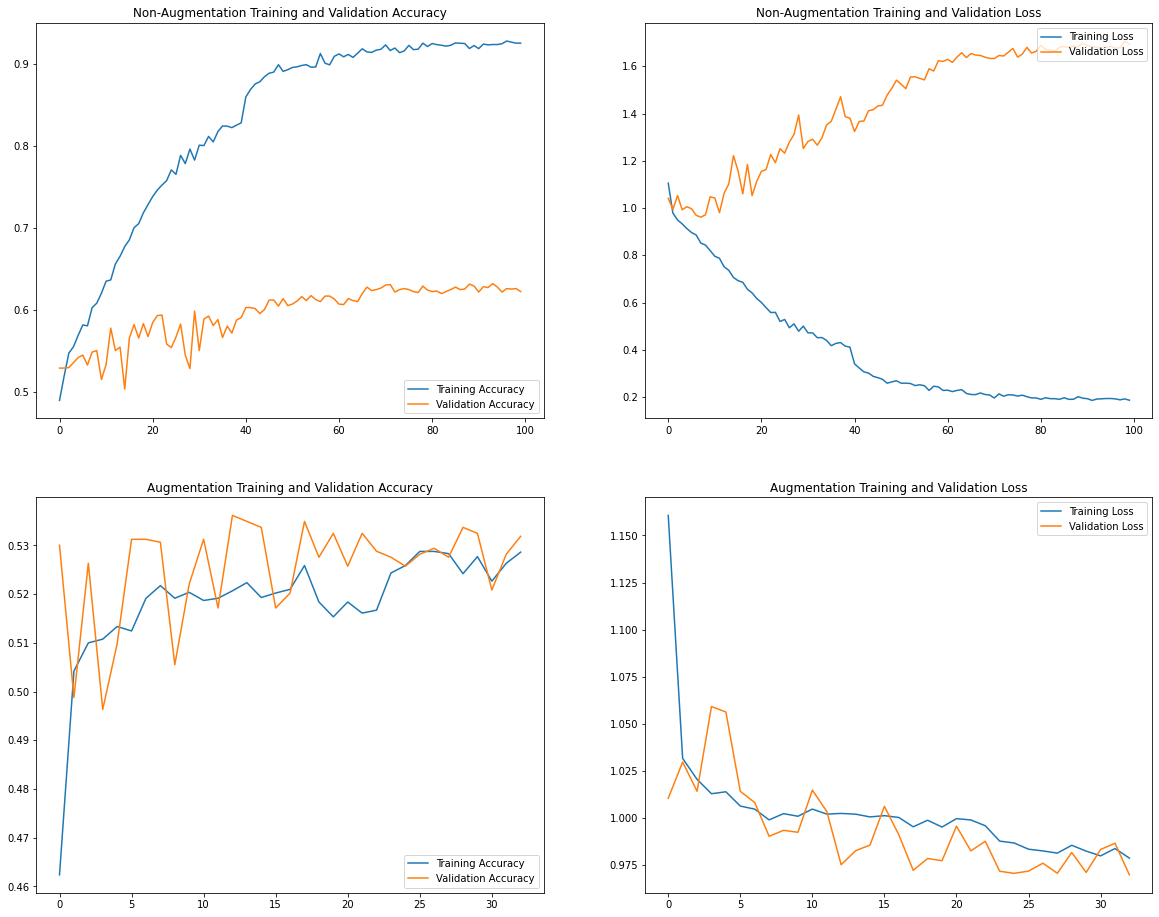

In [41]:
plt.figure(figsize=(20, 16))

plt.subplot(2, 2, 1)
plt.plot(history_resnet50.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet50.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Non-Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(history_resnet50.history['loss'], label='Training Loss')
plt.plot(history_resnet50.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Non-Augmentation Training and Validation Loss')

plt.subplot(2, 2, 3)
plt.plot(history_resnet50_ag.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet50_ag.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 4)
plt.plot(history_resnet50_ag.history['loss'], label='Training Loss')
plt.plot(history_resnet50_ag.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Augmentation Training and Validation Loss')

plt.show()

# **모델진단**

## test data

In [ ]:
# test data

#test_y = pd.read_csv("../input/intel-mobileodt-cervical-cancer-screening/solution_stg1_release.csv")
#test_y.loc[1,['Type_1','Type_2','Type_3']]

#root_dir = '../input/intel-mobileodt-cervical-cancer-screening'
#test_dir = os.path.join(root_dir,'test', 'test')

#test_type = []
#test_features = []
#i=0
#for fn in tqdm(test_y[['image_name']].to_numpy()):
#    for filename in fn:
#        filepath = os.path.join(test_dir,filename)
#        img = cv2.imread(filepath)
#        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
#        resized_img = cv2.resize(img, (128, 128))
#        test_features.append(np.array(resized_img))
#        test_type.append(np.array(test_y.loc[i,['Type_1','Type_2','Type_3']]))
#        i=i+1
    
#X_test = np.array(test_features)
#y_test = np.array(test_type)

In [ ]:
# save test data as npy files

#np.save('/kaggle/working/X_test_128', X_test)
#np.save('/kaggle/working/y_test_128', y_test)

In [ ]:
# load data

X_test = np.load('../input/test128/X_test_128.npy')/255
y_test_onehot = np.load('../input/test128/y_test_128.npy', allow_pickle=True)

In [ ]:
ydf = pd.DataFrame(y_test_onehot)

In [ ]:
ydf[0] = ydf[0].replace(1, 't1')
ydf[1] = ydf[1].replace(1, 't2')
ydf[2] = ydf[2].replace(1, 't3')

In [ ]:
type1 = ydf[ydf[0].isin(['t1'])][0]
type2 = ydf[ydf[1].isin(['t2'])][1]
type3 = ydf[ydf[2].isin(['t3'])][2]

In [ ]:
type = pd.concat([type1, type2, type3])
type

In [ ]:
type = type.replace('t1',0)
type = type.replace('t2',1)
type = type.replace('t3',2)

In [ ]:
type = type.sort_index()
y_test = np.array(type)

In [ ]:
# categorical output
y_test

# model test

## VGG16 pretrained not-aug

In [ ]:
#load best weights
#vgg16.load_weights('vgg16.weights.hdf5')

In [ ]:
#test_gen = ImageDataGenerator().flow(X_test, y_test, batch_size = BATCH_SIZE)

In [ ]:
#vgg16.evaluate(test_gen)

In [ ]:
#y_pred_enc = vgg16.predict(X_test)        
#y_pred = [np.argmax(i) for i in y_pred_enc] 
#item = {
#      0: 'Type 1'
#    , 1: 'Type 2'
#    , 2: 'Type 3'
#}

#matrix = confusion_matrix(y_test, y_pred)
#df = pd.DataFrame(matrix)
#df.columns = item.values()
#df.index = item.values()
#        
#df

In [ ]:
#report = classification_report(y_test, y_pred)
#print(report)

In [ ]:
## 정밀도
#print(sklearn.metrics.precision_score(y_test, y_pred, average = 'micro'))
## 특이도
#print(sklearn.metrics.recall_score(y_test, y_pred, pos_label=0, average = 'micro'))
## 정밀도
#print(sklearn.metrics.recall_score(y_test, y_pred, average = 'micro'))

전이학습관련내용 확인
https://www.tensorflow.org/guide/keras/transfer_learning

## VGG16 Pretrained Aug

In [ ]:
#vgg16_ag.load_weights('vgg_ag.weights.hdf5')

In [ ]:
#test_gen = ImageDataGenerator(rotation_range = 40,
#                                zoom_range = 0.2,
#                                width_shift_range=0.2,
#                                height_shift_range=0.2,
#                                shear_range=0.2,
#                                horizontal_flip = True,
#                                vertical_flip = True).flow(X_test, y_test, batch_size = BATCH_SIZE)

In [ ]:
#vgg16_ag.evaluate(test_gen)

In [ ]:
#y_pred_enc = vgg16_ag.predict(X_test)        
#y_pred = [np.argmax(i) for i in y_pred_enc] 
#item = {
#      0: 'Type 1'
#    , 1: 'Type 2'
#    , 2: 'Type 3'
#}

#matrix = confusion_matrix(y_test, y_pred)
#df = pd.DataFrame(matrix)
#df.columns = item.values()
#df.index = item.values()
        
#df

In [ ]:
#report = classification_report(y_test, y_pred)
#print(report)